In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge, Lasso

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [37]:
df = pd.read_csv('laptop_price.csv',encoding='latin-1')

In [38]:
df.head(5)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [39]:
print(df.shape) #satır / sutun

(1303, 13)


In [40]:
df.isna().sum() #eksik deger

laptop_ID           0
Company             0
Product             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price_euros         0
dtype: int64

In [41]:
df.duplicated().sum() #tekrar eden verileri gösterir

0

In [42]:
df = df.drop_duplicates() # tekrar edenleri siler

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   Product           1303 non-null   object 
 3   TypeName          1303 non-null   object 
 4   Inches            1303 non-null   float64
 5   ScreenResolution  1303 non-null   object 
 6   Cpu               1303 non-null   object 
 7   Ram               1303 non-null   object 
 8   Memory            1303 non-null   object 
 9   Gpu               1303 non-null   object 
 10  OpSys             1303 non-null   object 
 11  Weight            1303 non-null   object 
 12  Price_euros       1303 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 132.5+ KB


In [44]:
df.nunique()

laptop_ID           1303
Company               19
Product              618
TypeName               6
Inches                18
ScreenResolution      40
Cpu                  118
Ram                    9
Memory                39
Gpu                  110
OpSys                  9
Weight               179
Price_euros          791
dtype: int64

In [45]:
df.describe()

,laptop_ID,Inches,Price_euros
count,1303.000000,1303.000000,1303.000000
mean,660.155794,15.017191,1123.686992
std,381.172104,1.426304,699.009043
min,1.000000,10.100000,174.000000
25%,331.500000,14.000000,599.000000
50%,659.000000,15.600000,977.000000
75%,990.500000,15.600000,1487.880000
max,1320.000000,18.400000,6099.000000


In [46]:
# veri tipine göre ayırma:
numeric_features = [feature for feature in df.columns if df[feature].dtype != 'object']
cat_features =     [feature for feature in df.columns if df[feature].dtype == 'object']
print("Numerical features: ", numeric_features)
print('Categorical features:', cat_features)


Numerical features:  ['laptop_ID', 'Inches', 'Price_euros']
Categorical features: ['Company', 'Product', 'TypeName', 'ScreenResolution', 'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight']


Veri Görselleştirme

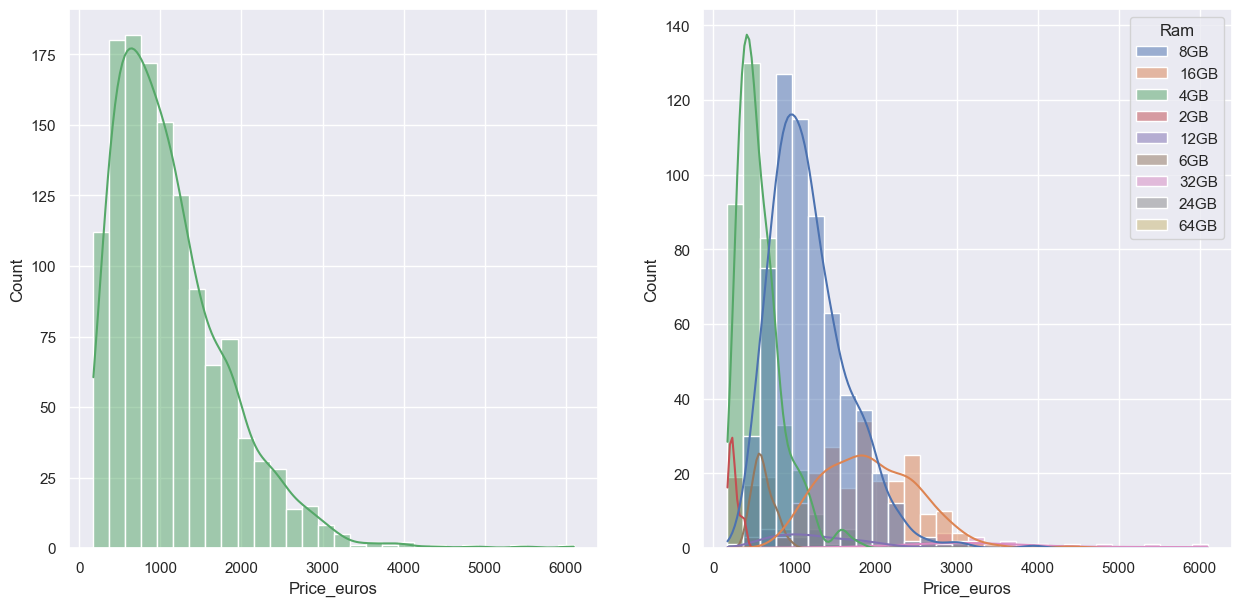

In [47]:
fig, axs = plt.subplots(1,2,figsize=(15,7))
plt.subplot(121)
sns.histplot(data=df, x='Price_euros', bins=30, kde=True, color='g')
plt.subplot(122)
sns.histplot(data=df, x='Price_euros', bins=30, kde=True, color='r', hue='Ram')
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

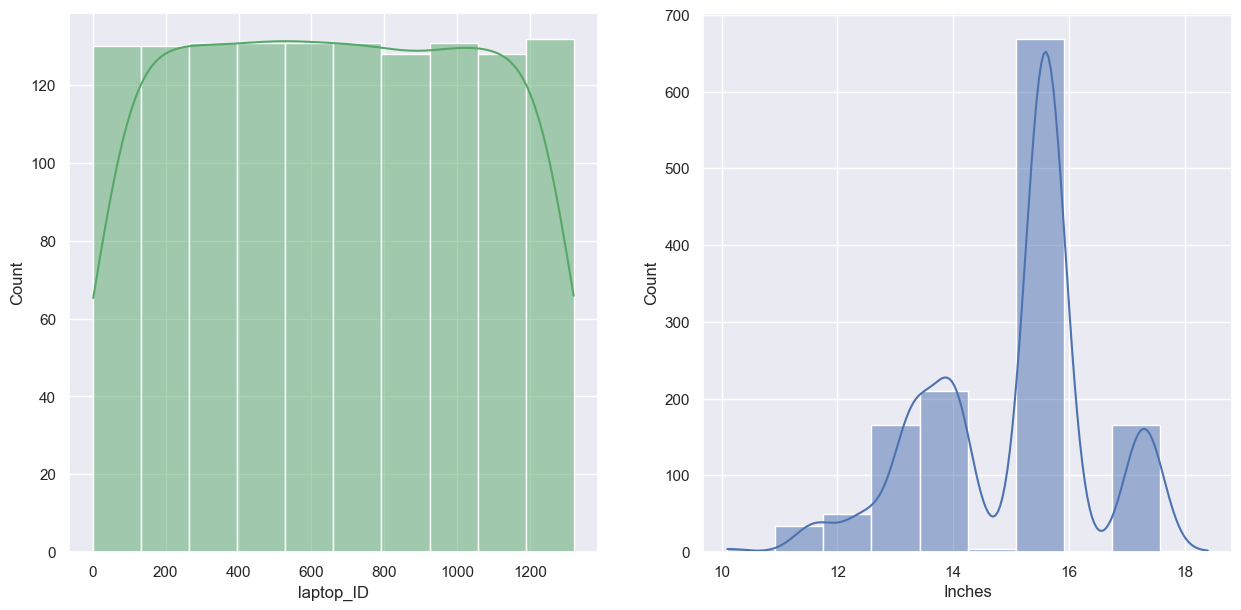

In [48]:
fig, axs = plt.subplots(1,2, figsize=(15,7))
plt.subplot(121)
sns.histplot(data=df, x='laptop_ID', bins=10, kde=True, color='g')
plt.subplot(122)
sns.histplot(data=df, x='Inches', kde=True, bins=10)
plt.show

In [49]:
# aykırı deger silmek için:
def removeOutliers(df, column):
     percentile25 = df[column].quantile(0.25)
     percentile75 = df[column].quantile(0.75)
     iqr = percentile75-percentile25
     upperLimit = percentile75 + 1.5 * iqr
     lowerLimit = percentile25 - 1.5 * iqr
     df = df[(df[column] < upperLimit) & (df[column] > lowerLimit)]
     return df

In [50]:
df = removeOutliers(df, 'Price_euros')
df = removeOutliers(df, 'laptop_ID')
df = removeOutliers(df, 'Inches')


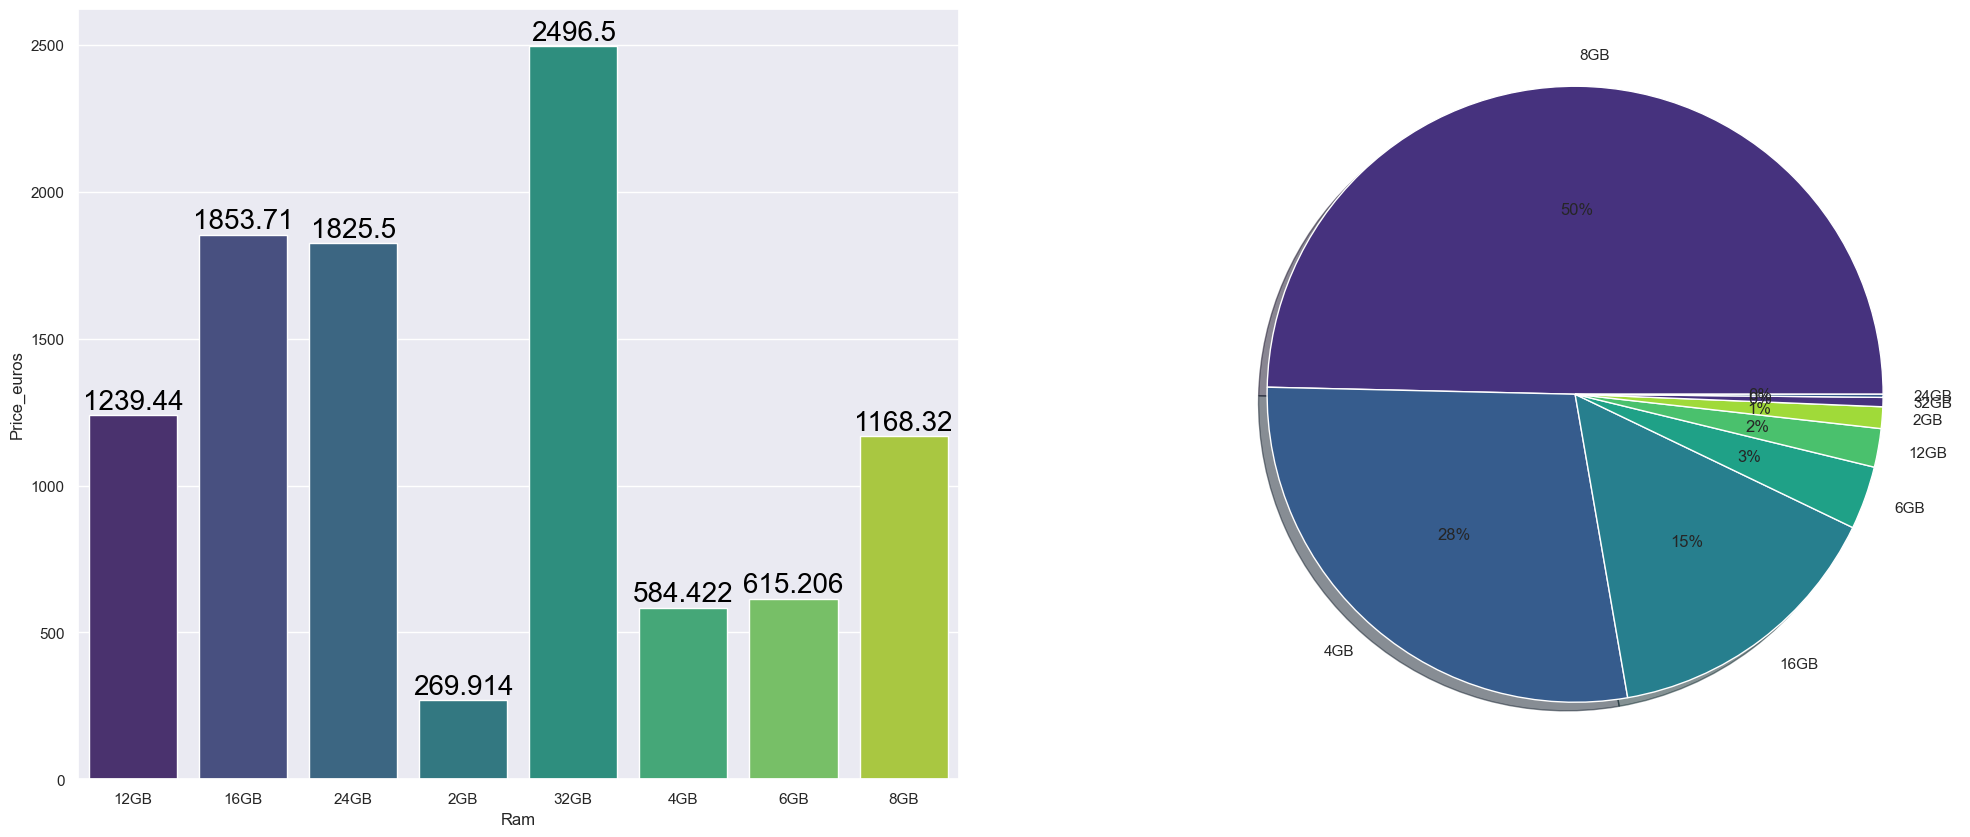

In [51]:
# pasta grafigi
f, ax = plt.subplots(1,2, figsize= (25,10))
groupData = df.groupby('Ram')
sns.barplot(x=groupData ['Price_euros'].mean().index, 
            y=groupData ['Price_euros'].mean().values,
            ax=ax[0], palette='viridis')

for container in ax[0].containers:
    ax[0].bar_label(container, color='black', size=20)
    ax[0].set_xlabel("Ram")
    ax[0].set_ylabel("Price_euros")

paletteColor = sns.color_palette('viridis')
plt.pie(x = df['Ram'].value_counts(),
        labels= df['Ram'].value_counts().index,
        autopct='%.0f%%', shadow=True, colors= paletteColor)
plt.show()


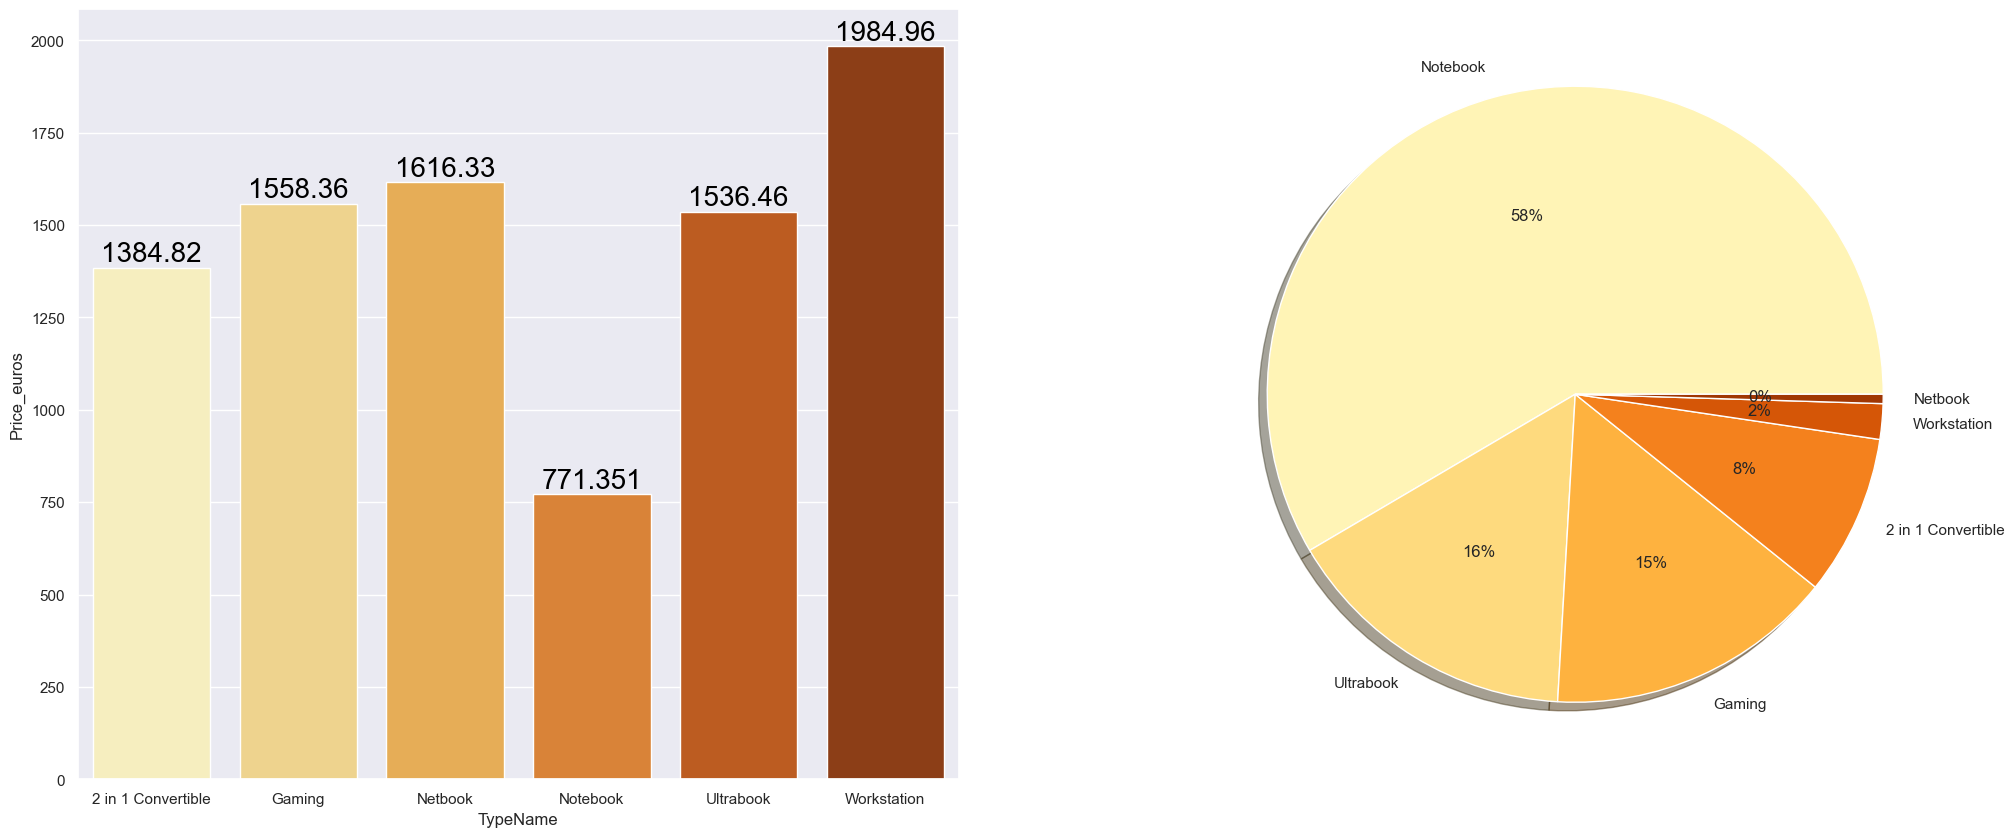

In [52]:
# pasta grafigi
f, ax = plt.subplots(1,2, figsize= (25,10))
groupData = df.groupby('TypeName')
sns.barplot(x=groupData ['Price_euros'].mean().index, 
            y=groupData ['Price_euros'].mean().values,
            ax=ax[0], palette='YlOrBr')

for container in ax[0].containers:
    ax[0].bar_label(container, color='black', size=20)
    ax[0].set_xlabel("TypeName")
    ax[0].set_ylabel("Price_euros")

paletteColor = sns.color_palette('YlOrBr')
plt.pie(x = df['TypeName'].value_counts(),
        labels= df['TypeName'].value_counts().index,
        autopct='%.0f%%', shadow=True, colors= paletteColor)
plt.show()


Text(0, 0.5, 'Price')

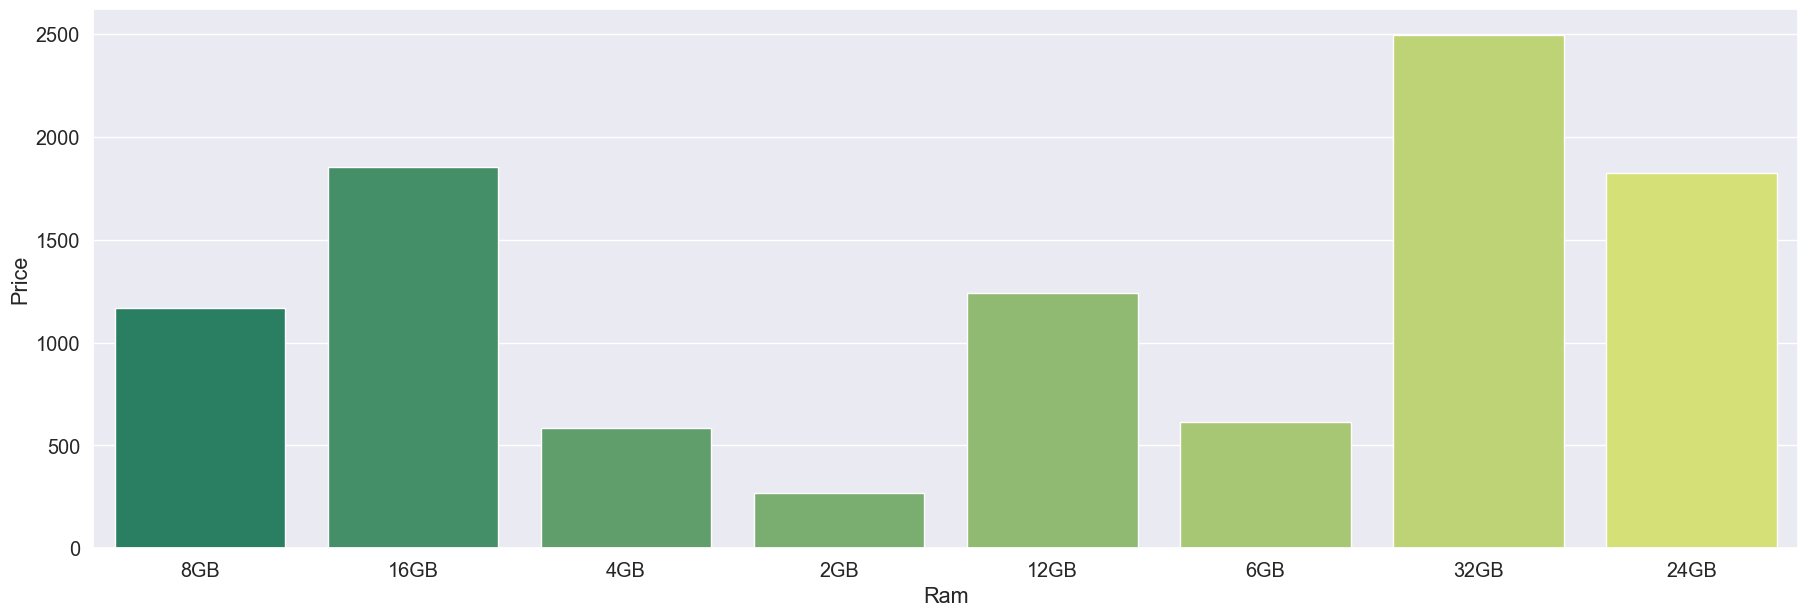

In [53]:
sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(22,7))

ax = sns.barplot(x=df['Ram'],
                 y = df['Price_euros'],
                 palette='summer',
                 ci=None)

plt.ylabel('Price')


Text(0, 0.5, 'Price')

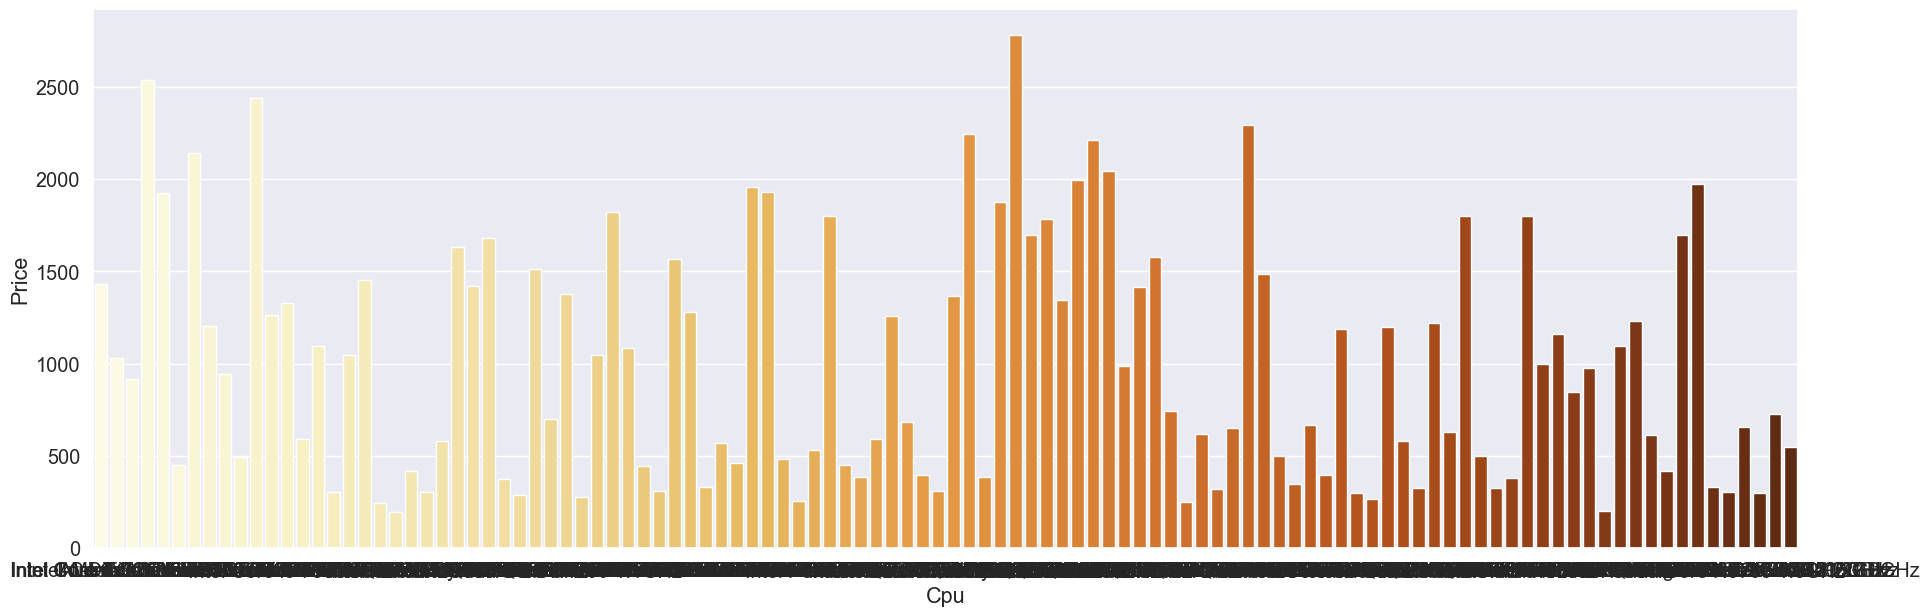

In [54]:
sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(22,7))

ax = sns.barplot(x=df['Cpu'],
                 y = df['Price_euros'],
                 #hue=df['Cpu'],
                 palette='YlOrBr',
                 ci=None)

plt.ylabel('Price')


Text(0, 0.5, 'Price')

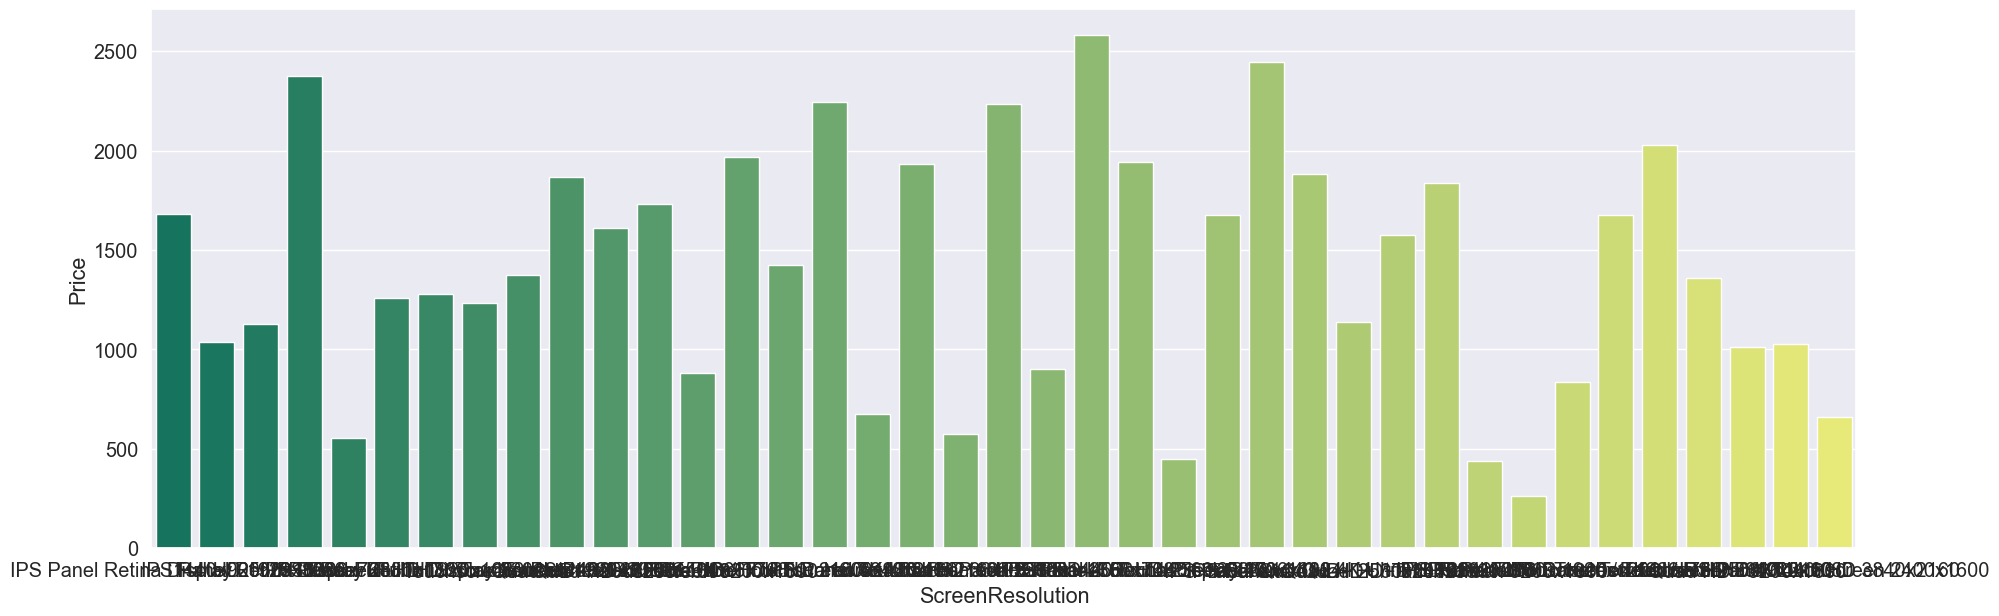

In [55]:
sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(22,7))

ax = sns.barplot(x=df['ScreenResolution'],
                 y = df['Price_euros'],
                 #hue=df['Cpu'],
                 palette='summer',
                 ci=None)

plt.ylabel('Price')


In [56]:
class LogScaling(BaseEstimator, TransformerMixin):
    def fit(self, X):
        return self
    
    def transform(self, X):
        return np.log1p(X)

In [57]:
df.describe()

,laptop_ID,Inches,Price_euros
count,1235.000000,1235.000000,1235.000000
mean,657.576518,15.091417,1088.451943
std,382.968967,1.280792,591.728043
min,1.000000,12.000000,196.000000
25%,325.500000,14.000000,618.995000
50%,655.000000,15.600000,979.000000
75%,992.500000,15.600000,1462.500000
max,1320.000000,17.300000,2813.750000


In [58]:
df.nunique()

laptop_ID           1235
Company               19
Product              579
TypeName               6
Inches                14
ScreenResolution      39
Cpu                  110
Ram                    8
Memory                36
Gpu                  101
OpSys                  8
Weight               172
Price_euros          746
dtype: int64

In [59]:
class TransformationPipeline:

    def __init__(self) -> None:
        pass
    
    def preprocess(self):
        cat_cols = df.select_dtypes('object').columns
        num_cols = ["laptop_ID","Inches"]

        num_pipeline= Pipeline(
            steps=[
            ("imputer",SimpleImputer(strategy="median")),
            ("scaler",StandardScaler())
            ]
        ) 

        cat_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("one_hot_encoder", OneHotEncoder(handle_unknown='ignore')),
        ("scaler", StandardScaler(with_mean=False))
    ]
)

        preprocessor = ColumnTransformer([
            ("log_transform", LogScaling(), num_cols),
            ("num_pipeline", num_pipeline, num_cols),
            ("cat_pipelines",cat_pipeline,cat_cols)
            ], remainder= 'passthrough')
        
        return preprocessor

In [60]:
X = df.drop('Price_euros', axis=1)
y = df.Price_euros

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state= 1)
X_train.shape, X_test.shape

((1111, 12), (124, 12))

In [62]:
preprocessor = TransformationPipeline().preprocess()

In [63]:

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

Modelleme

In [64]:
models = {
    'ridge' : Ridge(),
    'xgboost' : XGBRegressor(),
    'catboost' : CatBoostRegressor(verbose= 0),
    'lightgbm' : LGBMRegressor(),
    'gradinet boosting' : GradientBoostingRegressor(),
    'lasso' : Lasso(),
    'random forest' : RandomForestRegressor(),
    'support vector' : SVR(),
    'ada boost regressor' : AdaBoostRegressor()
}

In [65]:
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f'{name} trained')

ridge trained
xgboost trained
catboost trained
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 672
[LightGBM] [Info] Number of data points in the train set: 1111, number of used features: 74
[LightGBM] [Info] Start training from score 1089.950315
lightgbm trained
gradinet boosting trained
lasso trained
random forest trained
support vector trained
ada boost regressor trained


In [66]:
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

In [67]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(79))
model.add(tf.keras.layers.Dense(200))
model.add(tf.keras.layers.Dense(200))
model.add(tf.keras.layers.Dense(200))
model.add(tf.keras.layers.Dense(1))

model.compile(
    loss = 'rmse',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = [tf.keras.metrics.RootMeanSquaredError(name = 'rmse')]
)

model.fit(X_train.toarray(), y_train, validation_data=(X_test.toarray(), y_test), epochs = 50)

Epoch 1/50


ValueError: in user code:

    File "c:\Users\emreu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\emreu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\emreu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\emreu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\emreu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "c:\Users\emreu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\compile_utils.py", line 252, in __call__
        self.build(y_pred)
    File "c:\Users\emreu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\compile_utils.py", line 194, in build
        self._losses = tf.nest.map_structure(
    File "c:\Users\emreu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\compile_utils.py", line 365, in _get_loss_object
        loss = losses_mod.get(loss)
    File "c:\Users\emreu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\losses.py", line 2965, in get
        return deserialize(identifier, use_legacy_format=use_legacy_format)
    File "c:\Users\emreu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\losses.py", line 2912, in deserialize
        return legacy_serialization.deserialize_keras_object(
    File "c:\Users\emreu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\legacy\serialization.py", line 537, in deserialize_keras_object
        raise ValueError(

    ValueError: Unknown loss function: 'rmse'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.
